In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("500 lable แล้ว ไม่มีปริมาณ superclean - Sheet1.csv")

# Rename columns
df = df.rename(columns={"วัตถุดิบ_ไม่มีปริมาณ": "ingredients", "ชื่ออาหาร": "dish"})

# Drop missing values
df = df.dropna(subset=["ingredients", "dish"])

# Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["ingredients", "dish"]])
val_dataset = Dataset.from_pandas(val_df[["ingredients", "dish"]])
test_dataset = Dataset.from_pandas(test_df[["ingredients", "dish"]])

# Model loading
model = SentenceTransformer(
    'paraphrase-multilingual-mpnet-base-v2',
    model_card_data=SentenceTransformerModelCardData(
        language="th",
        license="apache-2.0",
        model_name="Thai Food Ingredients → Dish Prediction",
    )
)

# MultipleNegativesRankingLoss
train_samples = list(zip(train_dataset["ingredients"], train_dataset["dish"]))
val_samples = list(zip(val_dataset["ingredients"], val_dataset["dish"]))
test_samples = list(zip(test_dataset["ingredients"], test_dataset["dish"]))

# Convert samples into DatasetDict with correct format
def convert_to_dict(samples):
    return Dataset.from_dict({
        "anchor": [a for a, b in samples],
        "positive": [b for a, b in samples],
    })

train_dataset = convert_to_dict(train_samples)
val_dataset = convert_to_dict(val_samples)
test_dataset = convert_to_dict(test_samples)

# Create evaluator
from sentence_transformers.evaluation import InformationRetrievalEvaluator

# Build queries and corpus
val_queries = {f'q{i}': val_dataset['anchor'][i] for i in range(len(val_dataset))}
val_corpus = {f'd{i}': val_dataset['positive'][i] for i in range(len(val_dataset))}
val_relevant_docs = {f'q{i}': {f'd{i}'} for i in range(len(val_dataset))}

evaluator = InformationRetrievalEvaluator(
    queries=val_queries,
    corpus=val_corpus,
    relevant_docs=val_relevant_docs,
    name='thai-food-eval',
    show_progress_bar=True,
    precision_recall_at_k=[1, 3, 5]
)

# loss
loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir="models/thai-food-mpnet-tuned",
    num_train_epochs=6,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    learning_rate=5e-6,
    warmup_ratio=0.1,
    fp16=False,
    bf16=False,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    run_name="thai-food-retriever-tuned",
)

# trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss,
    evaluator=evaluator
)

# Train
trainer.train()

# Save the final model
model.save_pretrained("models/thai-food-mpnet/final6")

FileNotFoundError: [Errno 2] No such file or directory: '500 lable แล้ว ไม่มีปริมาณ superclean - Sheet1.csv'

Accuracy@1: 0.51
Accuracy@3: 0.67


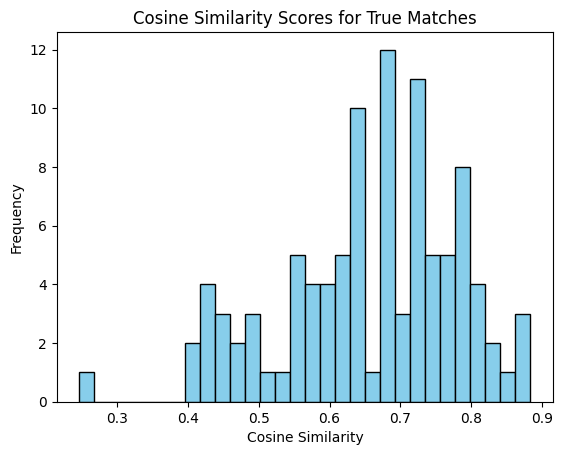

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("test set noisy 100 edit - Sheet1.csv")
model = SentenceTransformer("models/thai-food-mpnet/final6")

# Prepare data
noisy_queries = df["partial_noisy_ingredients"].astype(str).tolist()
clean_references = df["วัตถุดิบ"].astype(str).tolist()

# Encode clean ingredients once
clean_embeddings = model.encode(clean_references, convert_to_tensor=True)

# Variables to store results
correct_top1 = 0
correct_top3 = 0
cosine_scores_true_match = []

total = len(df)

for i in range(total):
    query = noisy_queries[i]
    query_emb = model.encode(query, convert_to_tensor=True)

    # Cosine similarity against all clean references
    cos_scores = util.cos_sim(query_emb, clean_embeddings)[0]

    # Get top 3
    top_k = 3
    top_k_indices = cos_scores.topk(k=top_k).indices.cpu().numpy()

    # Check if true match (index i) is within top 1 or top 3
    if top_k_indices[0] == i:
        correct_top1 += 1
    if i in top_k_indices:
        correct_top3 += 1

    # Record cosine similarity score of the true match (row i)
    cosine_scores_true_match.append(cos_scores[i].item())

# Calculate accuracy
accuracy_top1 = correct_top1 / total
accuracy_top3 = correct_top3 / total

print(f"Accuracy@1: {accuracy_top1:.2f}")
print(f"Accuracy@3: {accuracy_top3:.2f}")

plt.hist(cosine_scores_true_match, bins=30, color='skyblue', edgecolor='black')
plt.title("Cosine Similarity Scores for True Matches")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("500 lable แล้ว ไม่มีปริมาณ superclean - Sheet1.csv")

# Rename columns
df = df.rename(columns={"วัตถุดิบ_ไม่มีปริมาณ": "ingredients", "ชื่ออาหาร": "dish"})

# Drop missing values
df = df.dropna(subset=["ingredients", "dish"])

# Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["ingredients", "dish"]])
val_dataset = Dataset.from_pandas(val_df[["ingredients", "dish"]])
test_dataset = Dataset.from_pandas(test_df[["ingredients", "dish"]])

# Model loading
model = SentenceTransformer(
    'paraphrase-multilingual-mpnet-base-v2',
    model_card_data=SentenceTransformerModelCardData(
        language="th",
        license="apache-2.0",
        model_name="Thai Food Ingredients → Dish Prediction",
    )
)

# MultipleNegativesRankingLoss
train_samples = list(zip(train_dataset["ingredients"], train_dataset["dish"]))
val_samples = list(zip(val_dataset["ingredients"], val_dataset["dish"]))
test_samples = list(zip(test_dataset["ingredients"], test_dataset["dish"]))

# Convert samples into DatasetDict with correct format
def convert_to_dict(samples):
    return Dataset.from_dict({
        "anchor": [a for a, b in samples],
        "positive": [b for a, b in samples],
    })

train_dataset = convert_to_dict(train_samples)
val_dataset = convert_to_dict(val_samples)
test_dataset = convert_to_dict(test_samples)

# Create evaluator
from sentence_transformers.evaluation import InformationRetrievalEvaluator

# Build queries and corpus
val_queries = {f'q{i}': val_dataset['anchor'][i] for i in range(len(val_dataset))}
val_corpus = {f'd{i}': val_dataset['positive'][i] for i in range(len(val_dataset))}
val_relevant_docs = {f'q{i}': {f'd{i}'} for i in range(len(val_dataset))}

evaluator = InformationRetrievalEvaluator(
    queries=val_queries,
    corpus=val_corpus,
    relevant_docs=val_relevant_docs,
    name='thai-food-eval',
    show_progress_bar=True,
    precision_recall_at_k=[1, 3, 5]
)

# loss
loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir="models/thai-food-mpnet-tuned",
    num_train_epochs=12,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    learning_rate=5e-6,
    warmup_ratio=0.1,
    fp16=False,
    bf16=False,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    run_name="thai-food-retriever-tuned",
)

# trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss,
    evaluator=evaluator
)

# Train
trainer.train()

# Save the final model
model.save_pretrained("models/thai-food-mpnet/final7")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chanisorn-siri (chanisorn-siri-bodindecha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Thai-food-eval Cosine Accuracy@1,Thai-food-eval Cosine Accuracy@3,Thai-food-eval Cosine Accuracy@5,Thai-food-eval Cosine Accuracy@10,Thai-food-eval Cosine Precision@1,Thai-food-eval Cosine Precision@3,Thai-food-eval Cosine Precision@5,Thai-food-eval Cosine Recall@1,Thai-food-eval Cosine Recall@3,Thai-food-eval Cosine Recall@5,Thai-food-eval Cosine Ndcg@10,Thai-food-eval Cosine Mrr@10,Thai-food-eval Cosine Map@100
1,3.030100,2.092372,0.180000,0.340000,0.520000,0.800000,0.180000,0.113333,0.104000,0.180000,0.340000,0.520000,0.443526,0.335230,0.346947
2,1.827700,1.393485,0.400000,0.700000,0.820000,0.900000,0.400000,0.233333,0.164000,0.400000,0.700000,0.820000,0.649377,0.568690,0.575039
3,1.302200,1.152480,0.400000,0.680000,0.880000,0.940000,0.400000,0.226667,0.176000,0.400000,0.680000,0.880000,0.669494,0.582222,0.585649
4,1.252200,0.948005,0.480000,0.820000,0.880000,0.920000,0.480000,0.273333,0.176000,0.480000,0.820000,0.880000,0.714932,0.647000,0.652317
5,0.971000,0.870848,0.480000,0.840000,0.900000,0.960000,0.480000,0.280000,0.180000,0.480000,0.840000,0.900000,0.731880,0.657389,0.659365
6,0.831100,0.811559,0.480000,0.860000,0.900000,0.980000,0.480000,0.286667,0.180000,0.480000,0.860000,0.900000,0.738759,0.660778,0.661611
7,0.726100,0.806938,0.540000,0.860000,0.880000,0.960000,0.540000,0.286667,0.176000,0.540000,0.860000,0.880000,0.761550,0.697278,0.699744
8,0.828900,0.818795,0.560000,0.860000,0.880000,0.940000,0.560000,0.286667,0.176000,0.560000,0.860000,0.880000,0.760292,0.701722,0.705165
9,0.613700,0.801532,0.600000,0.860000,0.880000,0.940000,0.600000,0.286667,0.176000,0.600000,0.860000,0.880000,0.774536,0.721079,0.724765
10,0.619000,0.796746,0.580000,0.820000,0.880000,0.940000,0.580000,0.273333,0.176000,0.580000,0.820000,0.880000,0.764670,0.708024,0.711447


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("500 lable แล้ว ไม่มีปริมาณ superclean - Sheet1.csv")

# Rename columns
df = df.rename(columns={"วัตถุดิบ_ไม่มีปริมาณ": "ingredients", "ชื่ออาหาร": "dish"})

# Drop missing values
df = df.dropna(subset=["ingredients", "dish"])

# Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[["ingredients", "dish"]])
val_dataset = Dataset.from_pandas(val_df[["ingredients", "dish"]])
test_dataset = Dataset.from_pandas(test_df[["ingredients", "dish"]])

# Model loading
model = SentenceTransformer(
    'paraphrase-multilingual-mpnet-base-v2',
    model_card_data=SentenceTransformerModelCardData(
        language="th",
        license="apache-2.0",
        model_name="Thai Food Ingredients → Dish Prediction",
    )
)

# MultipleNegativesRankingLoss
train_samples = list(zip(train_dataset["ingredients"], train_dataset["dish"]))
val_samples = list(zip(val_dataset["ingredients"], val_dataset["dish"]))
test_samples = list(zip(test_dataset["ingredients"], test_dataset["dish"]))

# Convert samples into DatasetDict with correct format
def convert_to_dict(samples):
    return Dataset.from_dict({
        "anchor": [a for a, b in samples],
        "positive": [b for a, b in samples],
    })

train_dataset = convert_to_dict(train_samples)
val_dataset = convert_to_dict(val_samples)
test_dataset = convert_to_dict(test_samples)

# Create evaluator
from sentence_transformers.evaluation import InformationRetrievalEvaluator

# Build queries and corpus
val_queries = {f'q{i}': val_dataset['anchor'][i] for i in range(len(val_dataset))}
val_corpus = {f'd{i}': val_dataset['positive'][i] for i in range(len(val_dataset))}
val_relevant_docs = {f'q{i}': {f'd{i}'} for i in range(len(val_dataset))}

evaluator = InformationRetrievalEvaluator(
    queries=val_queries,
    corpus=val_corpus,
    relevant_docs=val_relevant_docs,
    name='thai-food-eval',
    show_progress_bar=True,
    precision_recall_at_k=[1, 3, 5]
)

# loss
loss = MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir="models/thai-food-mpnet-tuned",
    num_train_epochs=16,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    learning_rate=5e-6,
    warmup_ratio=0.1,
    fp16=False,
    bf16=False,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="steps",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    run_name="thai-food-retriever-tuned",
)

# trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss,
    evaluator=evaluator
)

# Train
trainer.train()

# Save the final model
model.save_pretrained("models/thai-food-mpnet/final8")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chanisorn-siri (chanisorn-siri-bodindecha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Thai-food-eval Cosine Accuracy@1,Thai-food-eval Cosine Accuracy@3,Thai-food-eval Cosine Accuracy@5,Thai-food-eval Cosine Accuracy@10,Thai-food-eval Cosine Precision@1,Thai-food-eval Cosine Precision@3,Thai-food-eval Cosine Precision@5,Thai-food-eval Cosine Recall@1,Thai-food-eval Cosine Recall@3,Thai-food-eval Cosine Recall@5,Thai-food-eval Cosine Ndcg@10,Thai-food-eval Cosine Mrr@10,Thai-food-eval Cosine Map@100
1,3.063100,2.291863,0.180000,0.360000,0.460000,0.660000,0.180000,0.120000,0.092000,0.180000,0.360000,0.460000,0.390738,0.308119,0.329486
2,1.957600,1.425837,0.400000,0.660000,0.820000,0.880000,0.400000,0.220000,0.164000,0.400000,0.660000,0.820000,0.638204,0.560024,0.567742
3,1.344500,1.165833,0.420000,0.680000,0.860000,0.920000,0.420000,0.226667,0.172000,0.420000,0.680000,0.860000,0.670242,0.589333,0.594426
4,1.277000,0.952300,0.480000,0.860000,0.900000,0.920000,0.480000,0.286667,0.180000,0.480000,0.860000,0.900000,0.720936,0.654333,0.659369
5,0.974400,0.868714,0.500000,0.840000,0.900000,0.960000,0.500000,0.280000,0.180000,0.500000,0.840000,0.900000,0.736643,0.664056,0.665908
6,0.816700,0.805083,0.500000,0.860000,0.900000,0.980000,0.500000,0.286667,0.180000,0.500000,0.860000,0.900000,0.751775,0.678000,0.678769
7,0.705200,0.811694,0.540000,0.840000,0.880000,0.940000,0.540000,0.280000,0.176000,0.540000,0.840000,0.880000,0.754143,0.693389,0.697340
8,0.779600,0.820951,0.580000,0.840000,0.900000,0.940000,0.580000,0.280000,0.180000,0.580000,0.840000,0.900000,0.764220,0.707222,0.710473
9,0.553300,0.797960,0.580000,0.860000,0.880000,0.940000,0.580000,0.286667,0.176000,0.580000,0.860000,0.880000,0.770519,0.715167,0.718611
10,0.538500,0.799421,0.580000,0.800000,0.900000,0.940000,0.580000,0.266667,0.180000,0.580000,0.800000,0.900000,0.762969,0.705524,0.708198


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.create_model_card()
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1748188312.ce588df1f6f3.3202.0:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Chanisorn/thai-food-mpnet-tuned/commit/a1bef135d4a4f87427b68a199ba781b1fbd6011a', commit_message='End of training', commit_description='', oid='a1bef135d4a4f87427b68a199ba781b1fbd6011a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Chanisorn/thai-food-mpnet-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Chanisorn/thai-food-mpnet-tuned'), pr_revision=None, pr_num=None)

อัปทับตัวเก่าที่ acc 0.49


Accuracy@1: 0.62
Accuracy@3: 0.78


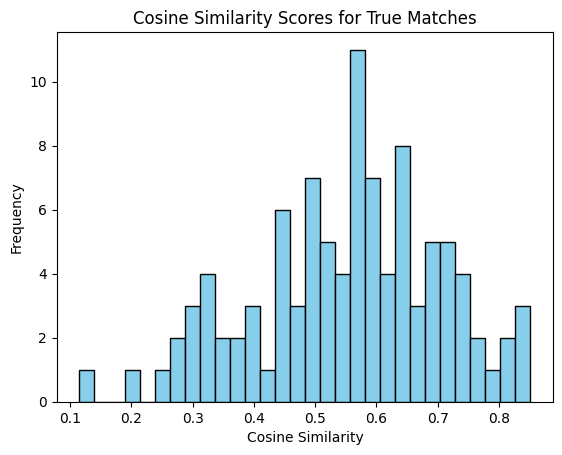

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("test set noisy 100 edit - Sheet1.csv")
model = SentenceTransformer("models/thai-food-mpnet/final8")

# Prepare data
noisy_queries = df["partial_noisy_ingredients"].astype(str).tolist()
clean_references = df["วัตถุดิบ"].astype(str).tolist()

# Encode clean ingredients once
clean_embeddings = model.encode(clean_references, convert_to_tensor=True)

# Variables to store results
correct_top1 = 0
correct_top3 = 0
cosine_scores_true_match = []

total = len(df)

for i in range(total):
    query = noisy_queries[i]
    query_emb = model.encode(query, convert_to_tensor=True)

    # Cosine similarity against all clean references
    cos_scores = util.cos_sim(query_emb, clean_embeddings)[0]

    # Get top 3
    top_k = 3
    top_k_indices = cos_scores.topk(k=top_k).indices.cpu().numpy()

    # Check if true match (index i) is within top 1 or top 3
    if top_k_indices[0] == i:
        correct_top1 += 1
    if i in top_k_indices:
        correct_top3 += 1

    # Record cosine similarity score of the true match (row i)
    cosine_scores_true_match.append(cos_scores[i].item())

# Calculate accuracy
accuracy_top1 = correct_top1 / total
accuracy_top3 = correct_top3 / total

print(f"Accuracy@1: {accuracy_top1:.2f}")
print(f"Accuracy@3: {accuracy_top3:.2f}")

plt.hist(cosine_scores_true_match, bins=30, color='skyblue', edgecolor='black')
plt.title("Cosine Similarity Scores for True Matches")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

best acc!!!!! https://huggingface.co/Chanisorn/thai-food-mpnet-tuned